In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv
/kaggle/input/auto-ru-data/all_auto_ru_09_09_2020.csv


# 1. Загрузка

## 1.1 Загрузка данных

In [2]:
train = pd.read_csv('../input/auto-ru-data/all_auto_ru_09_09_2020.csv') # новые данные
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv') # дано
sample_submission = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv') 


display(train.head(2))
display(test.head(2))

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [3]:
print(train.price.isna().any())
train.price.shape

True


(89378,)

In [4]:
train.dropna(subset=['price'], inplace=True) # бесполезная для нас информация

In [5]:
print(train.price.isna().any())
train.price.shape

False


(88968,)

In [6]:
#  Позаимствовано у vyushmanov.  проверка на схожесть таблиц
def check_df_before_merg(d_df1,d_df2):
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_dict['# unique_train'] = d_df1.nunique().values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_dict2['# unique_test'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_insert = pd.DataFrame(columns=['< - >'])
    
    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)
        if temp_df3['# unique_test'][i]>0 and temp_df3['# unique_train'][i]/temp_df3['# unique_test'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)



    
check_df_before_merg(train, test)

,feature_train,type_train,sample_train,# unique_train,< - >,feature_test,type_test,sample_test,# unique_test
0,bodyType,object,Седан,168.0,| - |,bodyType,object,лифтбек,24.0
1,brand,object,AUDI,36.0,| - |,brand,object,SKODA,12.0
2,color,object,007F00,16.0,| - |,color,object,серый,16.0
3,fuelType,object,бензин,6.0,| - |,fuelType,object,бензин,5.0
4,modelDate,float64,1990.000000,78.0,| - |,modelDate,int64,2008,66.0
5,name,object,2.8 MT (174 л.с.),4484.0,| - |,name,object,2.0 AMT (200 л.с.),2780.0
6,numberOfDoors,float64,4.000000,5.0,| - |,numberOfDoors,int64,5,5.0
7,productionDate,int64,1993,80.0,| - |,productionDate,int64,2012,69.0
8,vehicleConfiguration,object,SEDAN MECHANICAL 2.8,1860.0,| - |,vehicleConfiguration,object,LIFTBACK ROBOT 2.0,634.0
9,vehicleTransmission,object,MECHANICAL,4.0,| - |,vehicleTransmission,object,роботизированная,4.0


Резюме:
 1. Не совпали типы в:= 22 столбцах

2. Уникальные значения различаются в:= 5 столбцах [0, 1, 8, 10, 12]


,feature_train,не совпадают типы,feature_test
index,,,
4,modelDate,float64 != int64,modelDate
6,numberOfDoors,float64 != int64,numberOfDoors
11,enginePower,float64 != object,enginePower
14,Комплектация,object != nan,NaN
17,Состояние,float64 != object,Состояние
18,Владельцы,float64 != object,Владельцы
20,Таможня,bool != object,Таможня
22,price,float64 != nan,NaN
23,start_date,object != nan,NaN


22 столбца... а должен быть только один с зависимой переменной
разберемся с разногласиями таблиц до соединения

## 1.2 Разбираемся с колонками

### 1.2.1 modelDate

In [7]:
train.modelDate.fillna(0,inplace=True)
train['modelDate'] = train['modelDate'].astype('int64')
test.rename(columns = {'model_name':'model'}, inplace = True) 

### 1.2.2 numberofDoors

In [8]:
train.numberOfDoors.fillna(4,inplace=True)
train.numberOfDoors = train.numberOfDoors.astype(int)

### 1.2.3 enginePower

In [9]:
import re
pattern = re.compile('^(\d+)\.*')
test['enginePower'] = test['enginePower'].apply(lambda x: int(str(pattern.findall(x))[2:-2]))
test['enginePower'] = test['enginePower'].astype('int')
train['enginePower'].fillna(train['enginePower'].mode()[0], inplace=True)
train['enginePower'] = train['enginePower'].astype('int')

### 1.2.4 Owners

In [10]:
print("Train :\n",train.Владельцы.value_counts(), "\n\n","="*20)
print("Test :\n",test.Владельцы.value_counts())

Train :
 3.0    36099
2.0    20902
1.0    18398
Name: Владельцы, dtype: int64 

Test :
 3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64


In [11]:
train['Владельцы'].fillna(0, inplace=True)
#train['Владельцы'].fillna(1, inplace=True)
train['Владельцы'] = train['Владельцы'].astype('int64')
test['Владельцы'] = test['Владельцы'].map({'3 или более':4, 4:4,  3.0:3, 
                                           '3 или более':3, 2.0:2,'2\xa0владельца':2, 1.0:1, 
                                           '1\xa0владелец':1})


In [12]:
print("Train :\n",train.Владельцы.value_counts(), "\n\n","="*20)
print("Test :\n",test.Владельцы.value_counts())

Train :
 3    36099
2    20902
1    18398
0    13569
Name: Владельцы, dtype: int64 

Test :
 3    15957
1     9459
2     9270
Name: Владельцы, dtype: int64


### 1.2.5 Vendor
здесь я присвоил праворульным машинам Японское происхождение так как у нас равное количество значений переменных руля и производителя

In [13]:
form = lambda x: x.replace('RIGHT','JAPANESE') if x == 'RIGHT' else x.replace('LEFT',"EUROPEAN")
train['vendor'] = train['Руль'].map(form)

### 1.2.6 bodyType

In [14]:
test['body_type'] = [str(x).lower().replace('.', '') for x in test['bodyType']]
train['body_type'] = [str(x).lower() for x in train['bodyType']]

# Заменим длинные типы в train'е на обобщенные значения
body_type_list = list(test['body_type'].unique())
def get_perf_type(x, body_type_list):
    for t in body_type_list:
        if t in x:
            return t
        else: continue
    else: return '0'
    
train['body_type'] = train['body_type'].apply(lambda x: get_perf_type(x, body_type_list))

# Удалим 7 предложений, для которых не нашлось соответствия типа кузова
train = train[train['body_type']!='0']
train.drop(columns=['bodyType'], inplace=True)
test.drop(columns=['bodyType'], inplace=True)

### 1.2.7 CoLoR

In [15]:
dict_color = {'чёрный': '040001',
 'красный': 'EE1D19',
 'синий': '0000CC',
 'серебристый': 'CACECB',
 'зелёный': '007F00',
 'белый': 'FAFBFB',
 'серый': '97948F',
 'голубой': '22A0F8',
 'пурпурный': '660099',
 'коричневый': '200204',
 'бежевый': 'C49648',
 'золотистый': 'DEA522',
 'фиолетовый': '4A2197',
 'жёлтый': 'FFD600',
 'оранжевый': 'FF8649',
 'розовый': 'FFC0CB'}
test['color']=test['color'].map(dict_color)

### 1.2.8 engine

In [16]:
pattern = re.compile('(\d{1}\.\d{1})')
train['engine'] = train['name'].apply(lambda x:str(pattern.findall(str(x)))[2:5])
train['engine'] = pd.to_numeric(train['engine'], errors='coerce')
train['hybrid'] = train['name'].apply(lambda x: 1 if 'hyb' in x else 0)

test['engine'] = test['name'].apply(lambda x:str(pattern.findall(str(x)))[2:5])
test['engine'] = pd.to_numeric(test['engine'], errors='coerce')
test['hybrid'] = test['name'].apply(lambda x: 1 if 'hyb' in x else 0)

### 1.2.9 Transmission

In [17]:
test['vehicleTransmission'] = test['vehicleTransmission'].map({'AUTOMATIC':'AUTOMATIC', 'MECHANICAL':'MECHANICAL',
                                                                 'ROBOT':'ROBOT', 'VARIATOR':'VARIATOR','автоматическая':'AUTOMATIC', 'механическая':'MECHANICAL',
                                                                 'роботизированная':'ROBOT', 'вариатор':'VARIATOR'})

### 1.2.10 PTS

In [18]:
test['ПТС'].fillna('ORIGINAL',inplace=True)
test['ПТС'] = test['ПТС'].map({'Оригинал':'ORIGINAL', 'Дубликат':'DUPLICATE', 'ORIGINAL':'ORIGINAL', 'DUPLICATE':'DUPLICATE'})

### 1.2.11 Wheel

In [19]:
test['Руль'] = test['Руль'].map({'Правый':'RIGHT', 'Левый':'LEFT', 'RIGHT':'RIGHT', 'LEFT':'LEFT'})

In [20]:
# проверим таблицы снова
check_df_before_merg(train, test)

,feature_train,type_train,sample_train,# unique_train,< - >,feature_test,type_test,sample_test,# unique_test
0,brand,object,AUDI,36.0,| - |,brand,object,SKODA,12.0
1,color,object,007F00,16.0,| - |,color,object,97948F,16.0
2,fuelType,object,бензин,5.0,| - |,fuelType,object,бензин,5.0
3,modelDate,int64,1990,78.0,| - |,modelDate,int64,2008,66.0
4,name,object,2.8 MT (174 л.с.),4483.0,| - |,name,object,2.0 AMT (200 л.с.),2780.0
5,numberOfDoors,int64,4,5.0,| - |,numberOfDoors,int64,5,5.0
6,productionDate,int64,1993,80.0,| - |,productionDate,int64,2012,69.0
7,vehicleConfiguration,object,SEDAN MECHANICAL 2.8,1858.0,| - |,vehicleConfiguration,object,LIFTBACK ROBOT 2.0,634.0
8,vehicleTransmission,object,MECHANICAL,4.0,| - |,vehicleTransmission,object,ROBOT,4.0
9,engineDisplacement,object,2.8,534.0,| - |,engineDisplacement,object,2.0 LTR,55.0


Резюме:
 1. Не совпали типы в:= 15 столбцах

2. Уникальные значения различаются в:= 4 столбцах [0, 7, 9, 11]


,feature_train,не совпадают типы,feature_test
index,,,
13,Комплектация,object != nan,NaN
16,Состояние,float64 != object,Состояние
19,Таможня,bool != object,Таможня
21,price,float64 != nan,NaN
22,start_date,object != nan,NaN
23,hidden,float64 != nan,NaN
29,NaN,nan != object,car_url
30,NaN,nan != object,complectation_dict
31,NaN,nan != object,equipment_dict


## 1.3 Обогощение
перед тем как выбрасывать колонки, достану полезную информацию из них для дальнейшего

In [21]:
for data in [train,test]:
    data['description'] = data['description'].map(lambda x: str(x).lower())

    data['owner'] = data['description'].apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<200 else 0)
    data['showroom'] = data['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                                 or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                                 or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)


Некоторые столбцы train либо слишком долго обрабатывать, либо не несут в себе информации сильно улучшающих мои модели, я от них избавился:
* car_url - ничего нам не говорят, многие уже проданы
* image - красиво, но комп. зрением заниматься не будем
* hidden - все нан
* Состояние - пустое
* Таможня - все 1
* name - инфо уже есть в других колонках
* Комплектация - то же самое
* engineDisplacement не могу преобразовать, к скастью у меня есть описание, снего и достану значения... etc.

Сделаем то же и для теста


In [22]:
test_drop_cols = ['Состояние','Таможня','Владение','car_url','complectation_dict','description','equipment_dict',
                  'image','model_info','name','parsing_unixtime','priceCurrency','sell_id',
                'super_gen','vehicleConfiguration','engineDisplacement' ]
train_drop_cols = ['car_url', 'sell_id', 'image', 'hidden', 'parsing_unixtime', 'Состояние',
                   'vehicleConfiguration',''
                   'Таможня','Комплектация','name', 'description','Владение','start_date','engineDisplacement']

for col in train_drop_cols:
    if col in list(train.columns):
        train.drop(columns=[col], inplace=True)
for col in test_drop_cols:
    if col in list(test.columns):
        test.drop(columns=[col], inplace=True)

## 1.4 Соединяем таблицы
### 1.4.1 Обозначения тестовой выборки

In [23]:
train['sample'] = 1
test['sample'] = 0

### 1.4.2 Соеденим датасеты для предобработки

In [24]:
test['price'] = -1  # imaginary value for now
data = train.append(test, sort=False).reset_index(drop=True)

 ### 1.4.3 Что осталось?

In [25]:
data.isna().sum()

brand                    0
color                    0
fuelType                 0
modelDate                0
numberOfDoors            0
productionDate           0
vehicleTransmission      0
enginePower              0
mileage                  0
Привод                   0
Руль                     0
Владельцы                0
ПТС                    361
price                    0
model                    0
vendor                   0
body_type                0
engine                 164
hybrid                   0
owner                    0
showroom                 0
sample                   0
dtype: int64

In [26]:
# заполним оставшиеся пропуски
data['ПТС'].fillna('ORIGINAL', inplace=True) # оригинальный и так же самый частый
data['engine'].fillna(0, inplace=True) ## так как пропуски исключительно у электрокаров

# 2. EDA
фух...

Как говориться,
"Data scientists spend 80% of their time preparing and cleaning their data. They spend the other 20% of their time complaining about preparing and cleaning their data."

In [27]:
data

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,Привод,...,ПТС,price,model,vendor,body_type,engine,hybrid,owner,showroom,sample
0,AUDI,040001,бензин,1990,4,1991,MECHANICAL,174,350000,полный,...,ORIGINAL,200000.0,100,EUROPEAN,седан,2.8,0,0,0,1
1,AUDI,EE1D19,бензин,1982,4,1986,MECHANICAL,90,173424,передний,...,ORIGINAL,60000.0,100,EUROPEAN,седан,1.8,0,1,0,1
2,AUDI,0000CC,бензин,1988,5,1989,MECHANICAL,136,230000,полный,...,ORIGINAL,99000.0,100,EUROPEAN,универсал 5 дв,2.3,0,0,1,1
3,AUDI,CACECB,бензин,1988,4,1989,MECHANICAL,90,240000,передний,...,ORIGINAL,65000.0,100,EUROPEAN,седан,1.8,0,1,0,1
4,AUDI,040001,бензин,1990,4,1991,MECHANICAL,101,300000,передний,...,DUPLICATE,100000.0,100,EUROPEAN,седан,2.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123641,BMW,200204,бензин,2011,4,2014,AUTOMATIC,136,115000,задний,...,ORIGINAL,-1.0,3ER,EUROPEAN,седан,1.6,0,0,1,0
123642,BMW,040001,дизель,2016,4,2018,AUTOMATIC,190,98000,полный,...,ORIGINAL,-1.0,5ER,EUROPEAN,седан,2.0,0,1,0,0
123643,BMW,97948F,бензин,1995,4,1997,AUTOMATIC,170,360000,задний,...,DUPLICATE,-1.0,5ER,EUROPEAN,седан,2.5,0,1,0,0
123644,BMW,200204,дизель,2012,5,2013,AUTOMATIC,184,90500,полный,...,ORIGINAL,-1.0,X1,EUROPEAN,внедорожник 5 дв,2.0,0,1,1,0


## 2.1 Разделение колонки по дататипам

In [28]:

def fsort(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols):
    # функция которая разделит колонки датафрейма на разные категории
    #-----------------------------------------------------------------------------
    for col in df_raw.columns:
        
        if col in target_cols or col in time_cols or col in num_cols or col in bin_cols or col in cat_cols:
            continue
            
        elif len(df_raw[col].value_counts()) == 1:
                df_raw.drop(columns=[col], inplace=True)
                
        elif df_raw[col].dtype == np.datetime64:
            time_cols.append(col)
            
        elif df_raw[col].dtype == np.int or df_raw[col].dtype == np.float64:
            if len(df_raw[col].value_counts()) == 2:
                bin_cols.append(col)
            else: 
                num_cols.append(col)
                
        elif df_raw[col].dtype == np.object:
            cat_cols.append(col)
            
        else: 
            continue
        

    return target_cols, time_cols, num_cols, bin_cols, cat_cols

In [29]:
target_col = ['price']
num_cols, bin_cols, cat_cols, time_cols = [], [], [], []

target_cols,time_cols,num_cols,bin_cols,cat_cols = fsort(data,target_col,time_cols,num_cols,bin_cols,cat_cols)

In [30]:
print(target_cols,"time:\n",
      time_cols,
      "\nnum :\n",
      num_cols,
      "\nbin :\n",
      bin_cols,
      "\ncat :\n",cat_cols)

['price'] time:
 [] 
num :
 ['modelDate', 'numberOfDoors', 'productionDate', 'enginePower', 'mileage', 'Владельцы', 'engine'] 
bin :
 ['hybrid', 'owner', 'showroom', 'sample'] 
cat :
 ['brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Руль', 'ПТС', 'model', 'vendor', 'body_type']


In [31]:
# переставлю порядок колонок для более удобного анализа
data = data[['brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleTransmission',
       'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС',
       'model', 'vendor', 'body_type', 'engine', 'hybrid', 'owner', 'showroom',
       'sample', 'price']]

## 2.2 Строим графики

### 2.2.1 Correlation

<AxesSubplot:>

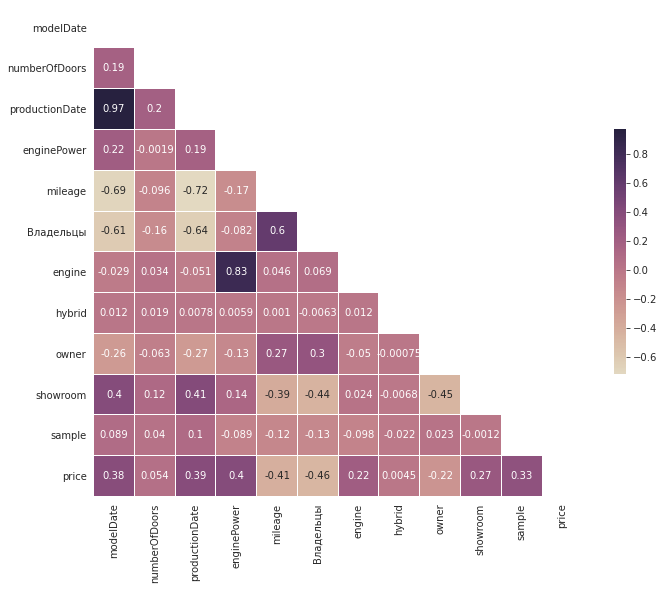

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute correlations
corr = data.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Add diverging colormap
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

# Draw correlation plot
sns.heatmap(corr,annot=True, mask=mask,linecolor = 'white', cmap=cmap, 
        square=True,
        linewidths=.02, cbar_kws={"shrink": .5}, ax=ax)

#### 2.2.1.2 мультиколлиниреальность
Замечена мультиколлиниреальность, посмотрим на сколько она значительная, и стоит ли преобразовать колонки или удалить их

In [33]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('price ~ modelDate+productionDate', data=data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif1 = pd.DataFrame()
vif1['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif1['variable'] = X.columns


y1, X1 = dmatrices('price ~ +engine+enginePower', data=data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif2 = pd.DataFrame()
vif2['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif2['variable'] = X1.columns

#view VIF for each explanatory variable 
display(vif1)

display(vif2)

,VIF,variable
0,81631.421361,Intercept
1,17.483107,modelDate
2,17.483107,productionDate


,VIF,variable
0,7.158930,Intercept
1,3.301757,engine
2,3.301757,enginePower


How to Interpret VIF Values

The value for VIF starts at 1 and has no upper limit.
A general rule of thumb for interpreting VIFs is as follows:

* A value of 1 indicates there is no correlation between a given explanatory variable and any other explanatory variables in the model.
* A value between 1 and 5 indicates moderate correlation between a given explanatory variable and other explanatory variables in the model, but this is often not severe enough to require attention.
* A value greater than 5 indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model. In this case, the coefficient estimates and p-values in the regression output are likely unreliable.

Given that each of the VIF values for the explanatory variables in our regression model are close to 1, multicollinearity is not a problem in our example.

In [34]:
data = data.drop(columns=['modelDate'])
num_cols = ['numberOfDoors',
 'productionDate',
 'enginePower',
 'mileage',
 'Владельцы',
 'engine']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


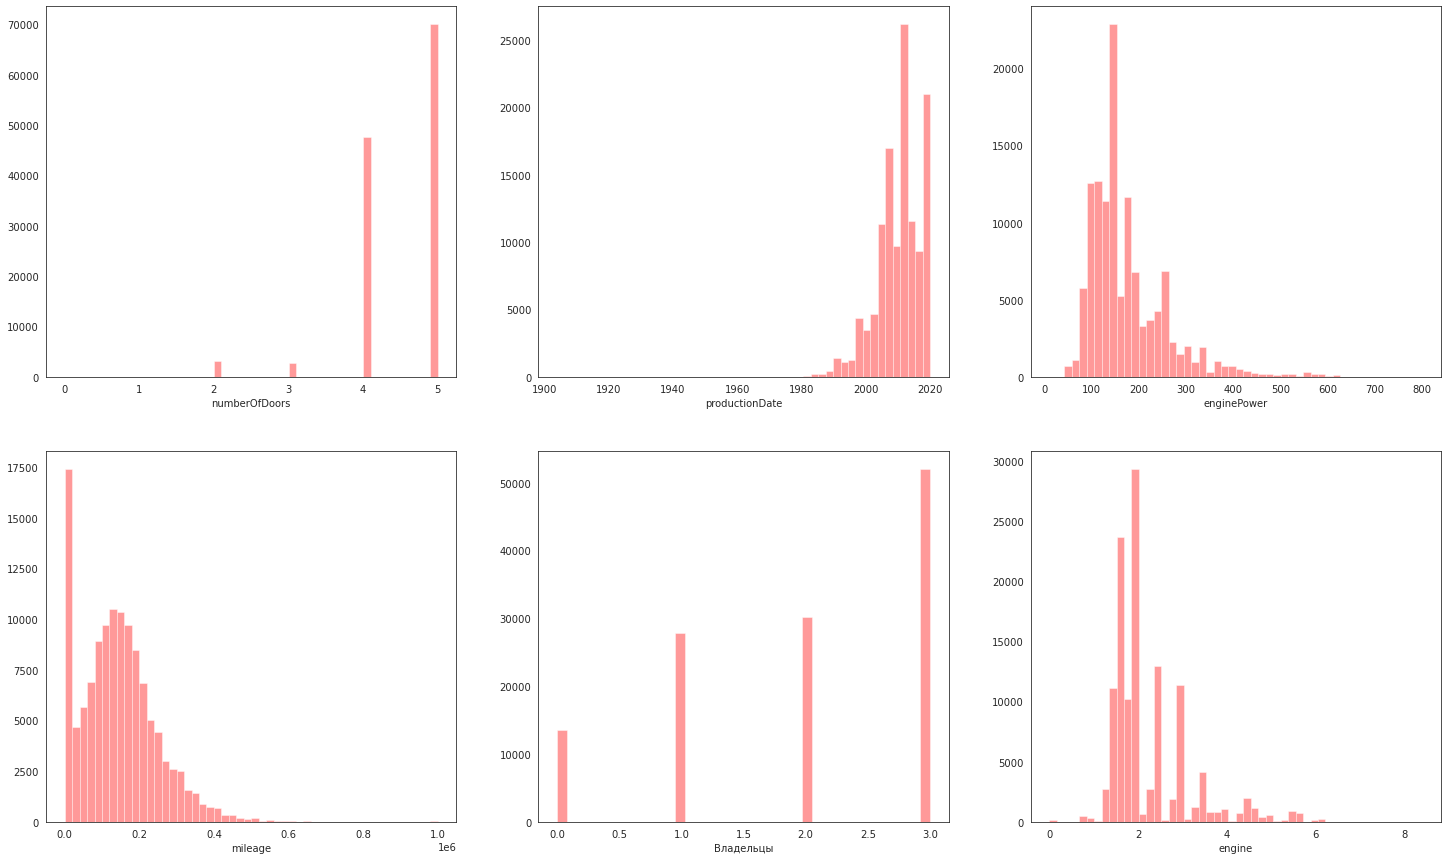

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(25,15))
for i,col in enumerate(data[num_cols].columns):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="r")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

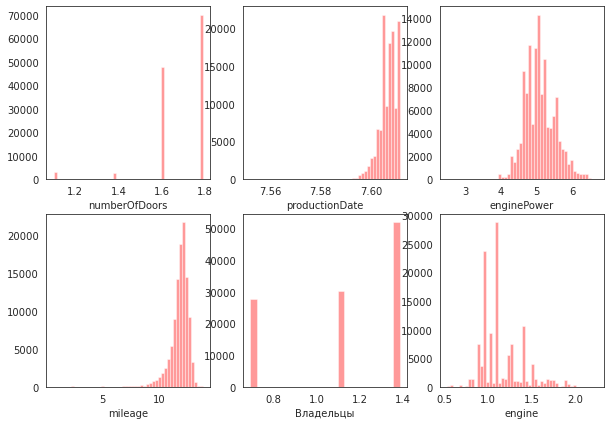

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(10,7))
for i,col in enumerate(data[num_cols].columns):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="r")

In [37]:
data['mileage'] = data.mileage.apply(lambda x: np.log(x+ 1))
data['enginePower'] = data.enginePower.apply(lambda x: np.log(x+ 1))

In [38]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=50)
reg.fit(data[num_cols], data.price)

RandomForestRegressor(n_estimators=50)

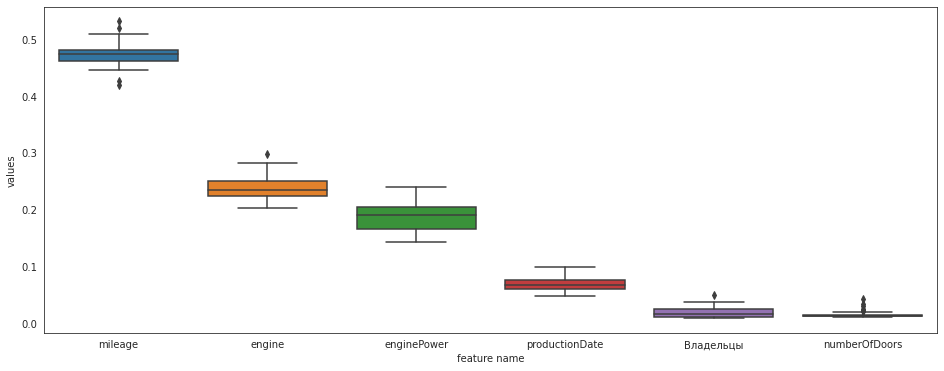

In [39]:
plt.rcParams['figure.figsize'] = (16, 6)
df_feature_importance = pd.DataFrame(reg.feature_importances_, index=data[num_cols].columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in reg.estimators_], columns=data[num_cols].columns)
df_feature_long = pd.melt(df_feature_all,var_name='feature name', value_name='values')
sns.boxplot(x="feature name", y="values", data=df_feature_long, order=df_feature_importance.index);

In [40]:
for c in data.columns:
    print("---- %s ---" % c)
    print("Unique values: ", data[c].nunique())
    print( data[c].value_counts())
    

---- brand ---
Unique values:  36
MERCEDES      12159
BMW           11838
VOLKSWAGEN    11515
NISSAN        10143
TOYOTA         8708
AUDI           7491
MITSUBISHI     6762
HYUNDAI        5703
KIA            5600
SKODA          5536
FORD           4780
CHEVROLET      3615
VOLVO          3525
OPEL           3100
RENAULT        2700
HONDA          2322
MAZDA          2296
INFINITI       1907
LEXUS          1880
PEUGEOT        1627
LAND_ROVER     1616
CITROEN        1140
DAEWOO         1034
SUBARU          930
SUZUKI          865
SSANG_YONG      714
PORSCHE         709
CHERY           562
JEEP            480
GREAT_WALL      418
DODGE           417
CHRYSLER        321
CADILLAC        319
JAGUAR          311
MINI            310
GEELY           293
Name: brand, dtype: int64
---- color ---
Unique values:  16
040001    36104
FAFBFB    21892
CACECB    15395
97948F    14757
0000CC    12113
EE1D19     6020
200204     5063
007F00     3542
C49648     2480
22A0F8     1849
DEA522     1037
660099    

In [41]:
data['age_bin'] = pd.cut(x=data['productionDate'], bins=[0,1980,1990,2000,2010,2020])

In [42]:
y3, X3 = dmatrices('price ~ +age_bin+productionDate', data=data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif3 = pd.DataFrame()
vif3['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif3['variable'] = X3.columns

#view VIF for each explanatory variable 
display(vif3)

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,variable
0,4.663811e+06,Intercept
1,NaN,"age_bin[T.Interval(1980, 1990, closed='right')]"
2,NaN,"age_bin[T.Interval(1990, 2000, closed='right')]"
3,NaN,"age_bin[T.Interval(2000, 2010, closed='right')]"
4,NaN,"age_bin[T.Interval(2010, 2020, closed='right')]"
5,1.000000e+00,productionDate


In [43]:
data.drop(columns='productionDate',inplace=True)
num_cols = ['numberOfDoors',
 'enginePower',
 'mileage',
 'Владельцы',
 'engine']

In [44]:
num_cols = ['enginePower','mileage'] #continuous values
le_cols = ['brand','color','model','body_type','engine','age_bin',
           #plus binary
          'Привод', 'Руль', 'vendor']
hot_cols = ['fuelType','numberOfDoors', 'vehicleTransmission','Владельцы','ПТС']# to onehotencode
ready_cols = ['hybrid', 'owner', 'showroom',
       'sample', 'price']# whatever is ready

In [45]:
len(data.columns) == len(num_cols)+len(le_cols)+len(hot_cols)+len(ready_cols)

True

# Preprocessing

In [46]:
dataset = data.copy()

In [47]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
dataset = reduce_mem_usage(dataset)

Memory usage after optimization is: 11.67 MB
Decreased by 38.5%


In [48]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
for column in le_cols:
    dataset[column] = le.fit_transform(dataset[column])

In [49]:
hot = OneHotEncoder()
for column in hot_cols:
    print(column)
    #reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
    hot_df = hot.fit_transform(dataset[column].values.reshape(-1,1)).toarray()
    print(hot_df)
    #To add this back into the original dataframe 
    dfOneHot = pd.DataFrame(hot_df, columns = [str(column)+"_"+str(int(i)) for i in range(len(dataset[column].value_counts()))])
    print(dfOneHot)
    dataset = pd.concat([dataset, dfOneHot], axis=1)
    print(dataset)
    #droping the country column 
    dataset= dataset.drop([column], axis=1) 
    print(dataset)


fuelType
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
        fuelType_0  fuelType_1  fuelType_2  fuelType_3  fuelType_4
0              1.0         0.0         0.0         0.0         0.0
1              1.0         0.0         0.0         0.0         0.0
2              1.0         0.0         0.0         0.0         0.0
3              1.0         0.0         0.0         0.0         0.0
4              1.0         0.0         0.0         0.0         0.0
...            ...         ...         ...         ...         ...
123641         1.0         0.0         0.0         0.0         0.0
123642         0.0         0.0         0.0         1.0         0.0
123643         1.0         0.0         0.0         0.0         0.0
123644         0.0         0.0         0.0         1.0         0.0
123645         0.0         0.0         0.0         1.0         0.0

[123646 rows x 5 columns]
        brand  color fuelType  numberOfDoors v

        vehicleTransmission_0  vehicleTransmission_1  vehicleTransmission_2  \
0                         0.0                    1.0                    0.0   
1                         0.0                    1.0                    0.0   
2                         0.0                    1.0                    0.0   
3                         0.0                    1.0                    0.0   
4                         0.0                    1.0                    0.0   
...                       ...                    ...                    ...   
123641                    1.0                    0.0                    0.0   
123642                    1.0                    0.0                    0.0   
123643                    1.0                    0.0                    0.0   
123644                    1.0                    0.0                    0.0   
123645                    1.0                    0.0                    0.0   

        vehicleTransmission_3  
0                  

        brand  color  enginePower   mileage  Привод  Руль        ПТС  model  \
0           0      2     1.819336  2.623047       2     0   ORIGINAL      1   
1           0     11     1.707031  2.570312       1     0   ORIGINAL      1   
2           0      0     1.778320  2.591797       2     0   ORIGINAL      1   
3           0      9     1.707031  2.593750       1     0   ORIGINAL      1   
4           0      2     1.727539  2.611328       1     0  DUPLICATE      1   
...       ...    ...          ...       ...     ...   ...        ...    ...   
123641      1      3     1.778320  2.537109       0     0   ORIGINAL     45   
123642      1      2     1.833008  2.525391       2     0   ORIGINAL     60   
123643      1      7     1.815430  2.625000       0     0  DUPLICATE     60   
123644      1      3     1.828125  2.519531       2     0   ORIGINAL   1052   
123645      1      2     1.866211  2.593750       2     0   ORIGINAL   1058   

        vendor  body_type  ...  numberOfDoors_3  nu

In [50]:
print(dataset.shape)
display(dataset)

(123646, 36)


,brand,color,enginePower,mileage,Привод,Руль,model,vendor,body_type,engine,...,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Владельцы_3,ПТС_0,ПТС_1
0,0,2,1.819336,2.623047,2,0,1,0,15,21,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0,11,1.707031,2.570312,1,0,1,0,15,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,0,1.778320,2.591797,2,0,1,0,19,16,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,9,1.707031,2.593750,1,0,1,0,15,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,2,1.727539,2.611328,1,0,1,0,15,13,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123641,1,3,1.778320,2.537109,0,0,45,0,15,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
123642,1,2,1.833008,2.525391,2,0,60,0,15,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
123643,1,7,1.815430,2.625000,0,0,60,0,15,18,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
123644,1,3,1.828125,2.519531,2,0,1052,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [51]:
def mape(y, y_pred, **kwargs):
    return np.mean(np.abs((y_pred-y)/y))*100

In [52]:
train = dataset[dataset['sample']==1]
train = train.drop(['sample'],axis=1)
test = dataset[dataset['sample']==0]
test = test.drop(columns=['sample','price'], axis=1)

from sklearn.model_selection import train_test_split
X = train.drop(['price'],axis=1)
y = train.price

# Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
test = sc.fit_transform(test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)

In [53]:
'''display(train.head())
display(test.head())'''

'display(train.head())\ndisplay(test.head())'

## Feature Extraction

# Training

In [54]:
# Naive Model
reg.fit(X_train, y_train)
display(mape(y_val, reg.predict(X_val)))

22.553403946241364

In [55]:
#training models

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


from sklearn.feature_selection import SelectKBest, f_regression
kb = SelectKBest(f_regression, k=2)
k_train = kb.fit_transform(X_train, np.log(y_train))
k_val = kb.transform(X_val)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [56]:
#RF
rfr = RandomForestRegressor(random_state=69
                      , n_estimators=300
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False)
# Gbr
gbr = GradientBoostingRegressor(random_state=69
                      , n_estimators=800
                      , min_samples_split=5
                      , min_samples_leaf=4
                      , max_features='sqrt'
                      , max_depth=9)
#xgb
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
etr = ExtraTreesRegressor()

In [57]:
'''y_pred = reg.fit(X, np.log(y)).predict(test)
y_pred = np.exp(y_pred)'''

'y_pred = reg.fit(X, np.log(y)).predict(test)\ny_pred = np.exp(y_pred)'

## Bagging

In [58]:
bagg_gbr = BaggingRegressor(gbr, n_estimators=3, n_jobs=-1, random_state=69)
bagg_rfr = BaggingRegressor(rfr, n_estimators=3, n_jobs=-1, random_state=69)
etr_bag = BaggingRegressor(etr, n_estimators=3, n_jobs=-1, random_state=69)
xgb_bag = BaggingRegressor(xgb_reg, n_estimators=3, n_jobs=-1, random_state=69)

In [59]:
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingCVRegressor
'''stack = StackingRegressor(regressors=[
    ('gbr',BaggingRegressor(BaggingRegressor(GradientBoostingRegressor(random_state=69
                      , n_estimators=800
                      , min_samples_split=5
                      , min_samples_leaf=4
                      , max_features='sqrt'
                      , max_depth=9), n_estimators=3, n_jobs=-1, random_state=69), n_estimators=3, n_jobs=-1, random_state=69),
    ('rfr', BaggingRegressor(RandomForestRegressor(random_state=69
                      , n_estimators=300
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False), n_estimators=3, n_jobs=-1, random_state=69)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)))], meta_regressor=MLPRegressor(max_iter=500),
                            random_state=69)'''
stack = StackingCVRegressor(regressors=(bagg_gbr, xgb_reg, etr, rfr),
                            meta_regressor=MLPRegressor(max_iter=500),
                            random_state=69)

In [60]:
import os, psutil  

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

In [61]:
cpu_stats()

'memory GB:1.1'

In [62]:
del train, test , data

In [63]:
cpu_stats()

'memory GB:1.1'

In [64]:
train = dataset[dataset['sample']==1]
train = train.drop(['sample'],axis=1)
test = dataset[dataset['sample']==0]
test = test.drop(columns=['sample','price'], axis=1)

In [65]:
#PCA
from sklearn.decomposition import IncrementalPCA
from scipy import sparse


X = train.drop(['price'],axis=1)
y = train.price


transformer = IncrementalPCA(n_components=20, batch_size=200)

# or let the fit function itself divide the data into batches
X_sparse = sparse.csr_matrix(X)
X_transformed = transformer.fit_transform(X_sparse)
print(X_transformed.shape)

Xt_sparse = sparse.csr_matrix(test)
Xt_transformed = transformer.fit_transform(Xt_sparse)
display(Xt_transformed.shape)

(88960, 20)


(34686, 20)

In [66]:
pd.DataFrame(Xt_transformed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,124.869300,10.995604,-6.611376,-4.067151,-7.315977,-0.026600,0.008023,0.104489,-0.729376,-0.995800,0.099885,-0.353195,-0.494231,0.405836,-0.614394,0.184031,-0.393847,-0.099258,0.021468,0.000427
1,124.882296,9.373408,-3.397639,-3.037568,-4.894652,-0.700875,-0.267730,-0.328634,-0.732349,-0.634700,-0.614964,0.212719,0.079655,-0.103119,0.624238,0.269135,0.152304,-0.066025,0.098964,-0.004043
2,359.858130,7.051040,-4.650177,-0.775903,0.428405,-0.810440,-0.405972,-0.218061,-0.763883,-0.706498,-0.310545,0.311264,-0.335719,-0.158824,-0.429503,-0.062268,-0.473282,-0.089730,0.023189,0.013370
3,124.882561,9.407167,-3.428928,-3.144272,-3.903060,-0.548667,-0.327881,0.322640,-0.126104,-0.375629,0.292445,1.096138,-0.185701,-0.224051,0.092902,0.634807,0.173688,-0.038506,0.008033,0.021260
4,124.891002,9.024339,-2.267950,-3.573818,5.224833,-0.848977,-0.477729,0.388880,-0.592343,-0.524916,0.394959,0.539814,-0.044311,-0.118971,0.274018,0.123938,0.190486,-0.080111,-0.009634,0.019566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,-514.451406,-8.903622,-11.623952,-0.919466,-2.943333,0.151499,-1.073385,0.477074,-0.553699,-0.400424,0.502511,-0.214676,0.120743,0.511709,-0.039332,0.383175,0.082428,-0.182076,0.016441,0.058284
34682,-499.439757,-10.841722,-8.363244,0.546202,-3.499232,-0.904283,0.456844,1.070337,0.543774,1.060033,-0.516867,0.604463,-0.060687,-0.173441,0.003554,-0.232397,0.112849,0.042710,-0.028863,-0.027179
34683,-499.425277,-12.707823,-4.518938,1.678364,2.014822,1.335683,-0.659889,0.474066,-0.066805,-0.292034,0.172230,0.246231,0.085041,-0.795482,-0.135389,0.119297,0.072712,-0.232165,-0.023753,0.054929
34684,492.572252,-20.973340,-15.849244,-3.381181,-3.068767,-0.479039,0.155909,0.690029,1.070940,0.109907,0.032683,-0.259421,0.281322,-0.120278,-0.153047,0.799028,-0.009216,0.035591,0.018404,0.012243


In [86]:
#Join before kbest
train_df = pd.concat([X, pd.DataFrame(X_transformed, index=X.index)], axis=1)
test_df = pd.concat([test, pd.DataFrame(Xt_transformed, index=test.index)], axis=1)

In [89]:
# Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(train_df)
test = sc.fit_transform(test_df)

In [92]:
# selectkbest
from sklearn.feature_selection import SelectKBest, f_regression
kb = SelectKBest(f_regression, k=20)
X_new = kb.fit_transform(X, np.log(y))
X_test_new = kb.transform(test)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [94]:
#Fitpredict

stack.fit(X_new, np.log(y))
y_pred = np.exp(stack.predict(X_test_new))

ValueError: X has a different shape than during fitting.

In [ ]:
VERSION = 4
sample_submission['price'] = y_pred
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)